# This notebook is used to solve a hamiltonian path problem travelling salesman problem using Genetic Algorithm and Best First Heuristic Search

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import time
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm,trange
from random import randint, seed,random
from collections import defaultdict
ox.config(log_console=True, use_cache=True)
seed(123)
pd.set_option('display.max_columns', 500)

### Calculate haversine distance using latitude and longitude

In [2]:
def calc_dist(site_A_lat,site_A_lon, site_B_lat,site_B_lon):
    
    R = 6373.0 #approx radius of earth
    
    site_A_lat_rad = radians(site_A_lat)
    site_A_lon_rad = radians(site_A_lon)
    site_B_lat_rad = radians(site_B_lat)
    site_B_lon_rad = radians(site_B_lon)
    
    dist_lat = site_B_lat_rad - site_A_lat_rad
    dist_lon = site_B_lon_rad - site_A_lon_rad
    
    a = sin(dist_lat / 2)**2 + cos(site_A_lat_rad) * cos(site_B_lat_rad) * sin(dist_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c


In [29]:
infile = '../data/wikivoyage-listings-en - Copy.csv'
figure_path = '../out/figures/'
# Retrieved from: Wikivoyage text mining by Nicolas Raoule, 
# https://data.world/nicolas-raoul/wikivoyage-points-of-interest

df = pd.read_csv(infile, header=0,skipinitialspace=True)
df = df[df['type']=='see']
df

article type                         title  \
2                   's-Hertogenbosch  see        Saint John's Cathedral   
3                   's-Hertogenbosch  see                   The Moriaan   
4                   's-Hertogenbosch  see                     Town Hall   
5                   's-Hertogenbosch  see      The North Brabant Museum   
6                   's-Hertogenbosch  see  City Museum 's-Hertogenbosch   
...                              ...  ...                           ...   
313462  Beijing/Dongzhimen and Ditan  see               The Poly Museum   
313463  Beijing/Dongzhimen and Ditan  see                       onemoon   
313464  Beijing/Dongzhimen and Ditan  see                    Ditan Park   
313465  Beijing/Dongzhimen and Ditan  see                   Liuyin Park   
313466  Beijing/Dongzhimen and Ditan  see               Qingnianhu Park   

                                                      alt wikidata  wikipedia  \
2                                    Sint Jans Kathedraal      NaN        NaN   
3                                                     NaN      NaN        NaN   
4                                                Stadhuis      NaN        NaN   
5                                    NoordBrabants Museum      NaN        NaN   
6                 Stedelijk Museum 's-Hertogenbosch (SMS)      NaN        NaN   
...                                                   ...      ...        ...   
313462                              保利博物馆; Bǎolì Bówùguǎn      NaN        NaN   
313463                                 一月当代; yīyuèdāngdài      NaN        NaN   
313464  地坛公园; Dìtán Gōngyuán; also known as Temple of ...      NaN        NaN   
313465                               柳荫公园; Liǔyìngōngyuán      NaN        NaN   
313466                          青年湖公园; Qīngniánhúgōngyuán      NaN        NaN   

                                                  address  \
2                                                     NaN   
3                                                     NaN   
4                                                 Markt 1   
5                                                     NaN   
6                                                     NaN   
...                                                   ...   
313462  14 Dongzhimen South Street (东直门南大街14号; Dōngzhí...   
313463  Inside Ditan Park, Andingmenwai (安定门外地坛公园; Ānd...   
313464   Andingmenwai Street (安定门外大街; Āndìngménwài Dàjiē)   
313465  Jiangzhaikou, Andingmenwai (安定门外蒋宅口; ānìngménw...   
313466    Andingmenwai Street (安定门外大街; āndìngménwàidàjiē)   

                                               directions             phone  \
2                                                     NaN               NaN   
3                                    on the market square               NaN   
4                         south side of the market square               NaN   
5                                                     NaN               NaN   
6       next to, and connected to, the North Brabant M...               NaN   
...                                                   ...               ...   
313462  Just northeast of Dongsishitiao Metro Station ...  +86 10 6500 8117   
313463                                 Just inside S gate  +86 10 6427 7748   
313464  300m north of Yonghegong Metro Station (lines ...  +86 10 6421 4657   
313465  Andingmen Metro Station and walk ten minutes; ...  +86 10 8411 3699   
313466  Between Andingmen and Gulou Outer streets just...  +86 10 8411 6321   

       tollFree                email               fax  \
2           NaN                  NaN               NaN   
3           NaN                  NaN               NaN   
4           NaN                  NaN               NaN   
5           NaN                  NaN               NaN   
6           NaN                  NaN               NaN   
...         ...                  ...               ...   
313462      NaN                  NaN  +86 10 6501 1277   
313463   

In [4]:
## Remove non existing geolocation records
df.dropna(subset=['latitude', 'longitude'], inplace=True)
df.head()

article type                         title  \
2  's-Hertogenbosch  see        Saint John's Cathedral   
3  's-Hertogenbosch  see                   The Moriaan   
4  's-Hertogenbosch  see                     Town Hall   
5  's-Hertogenbosch  see      The North Brabant Museum   
6  's-Hertogenbosch  see  City Museum 's-Hertogenbosch   

                                       alt wikidata  wikipedia  address  \
2                     Sint Jans Kathedraal      NaN        NaN      NaN   
3                                      NaN      NaN        NaN      NaN   
4                                 Stadhuis      NaN        NaN  Markt 1   
5                     NoordBrabants Museum      NaN        NaN      NaN   
6  Stedelijk Museum 's-Hertogenbosch (SMS)      NaN        NaN      NaN   

                                          directions phone tollFree email  \
2                                                NaN   NaN      NaN   NaN   
3                               on the market square   NaN      NaN   NaN   
4                    south side of the market square   NaN      NaN   NaN   
5                                                NaN   NaN      NaN   NaN   
6  next to, and connected to, the North Brabant M...   NaN      NaN   NaN   

   fax                                           url hours checkIn checkOut  \
2  NaN                                           NaN   NaN     NaN      NaN   
3  NaN                                           NaN   NaN     NaN      NaN   
4  NaN                                           NaN   NaN     NaN      NaN   
5  NaN  http://www.hetnoordbrabantsmuseum.nl/english   NaN     NaN      NaN   
6  NaN                           http://www.sm-s.nl/   NaN     NaN      NaN   

  image price  latitude  longitude  wifi  accessibility    lastEdit  \
2   NaN   NaN  51.68808    5.30814   NaN            NaN  2016-01-25   
3   NaN   NaN  51.68967    5.30261   NaN            NaN  2016-01-25   
4   NaN   NaN  51.68846    5.30315   NaN            NaN  2016-01-25   
5   NaN   NaN  51.68658    5.30469   NaN            NaN  2016-01-25   
6   NaN   NaN  51.68575    5.30419   NaN            NaN  2016-01-25   

                                         description  
2  one of the most prominent landmarks of Den Bos...  
3  the oldest brick building in The Netherlands, ...  
4  The facade was built in the 17th century and r...  
5  houses a collection of art and historical arti...  
6  A brand new building and a museum for modern a...

In [5]:
print(len(set(df['article'].tolist())))
set(df['article'].tolist())

7496


{'Semenic-Cheile Carașului National Park',
 'Dulnain Bridge',
 'Mullingar',
 'Mid-Hudson and Catskills',
 'Dundee',
 'Shakhrizabz',
 'Mevagissey',
 'New Rochelle',
 'Coleraine',
 'San Francisco/Haight',
 'Rhoose',
 'Debenham',
 'Dubai/Jumeirah',
 'Prudhoe',
 'Panglao',
 'Fort Lauderdale',
 'Ajaccio',
 'Caves',
 'Manhattan/Lower East Side',
 'Trogir',
 'Aluva',
 'Fort Worth',
 'Toronto/Downtown East',
 'Debarca',
 'Maringá (Paraná)',
 'Sharm el-Sheikh',
 'Raja Ampat',
 'Huila',
 'Lochinver',
 'Vero Beach',
 'Benllech',
 'Munnar',
 'Conceição da Barra',
 'Carleton Place',
 'Hornsherred',
 'Yorkshire Dales',
 'Necoclí',
 'Stavanger',
 'Haapsalu',
 'Van',
 'Artashat',
 'Fresno',
 'Naypyidaw',
 'Potter Heigham',
 'Westray',
 'Kondotty',
 'Devizes',
 "Tai'an",
 'Cook Strait ferries',
 'Tianjin',
 'Weimar',
 'Stockholm archipelago',
 'Leeds/North West',
 'Dandong',
 'Bonavista Peninsula',
 'Laufenburg',
 'South Moravia',
 'Newport (Monmouthshire)',
 'Sarnen',
 'Maradi',
 'Totnes',
 'Tampere',

In [6]:
# Format data
list_vals = []
for idx,row in df.iterrows():
    article = row['article']
    title = row['title']
    lat = row['latitude']
    lon = row['longitude']
    list_vals.append([article, title,lat,lon])
print(len(list_vals))
list_vals

42113


[["'s-Hertogenbosch", "Saint John's Cathedral", 51.68808, 5.30814],
 ["'s-Hertogenbosch", 'The Moriaan', 51.68967, 5.30261],
 ["'s-Hertogenbosch", 'Town Hall', 51.68846, 5.30315],
 ["'s-Hertogenbosch", 'The North Brabant Museum', 51.68658, 5.30469],
 ["'s-Hertogenbosch", "City Museum 's-Hertogenbosch", 51.68575, 5.30419],
 ["'s-Hertogenbosch", 'Jhyeronimus Bosch Art Center', 51.68807, 5.31215],
 ["'s-Hertogenbosch", 'Citadel', 51.69511, 5.30335],
 ["'s-Hertogenbosch", 'Kruithuis', 51.69357, 5.30497],
 ['Aachen', 'Aachen Cathedral', 50.77475, 6.083922],
 ['Aachen', 'Cathedral Treasury', 50.775048, 6.08282],
 ['Aachen', 'Rathaus', 50.776025, 6.08389],
 ['Aachen',
  'Ludwig Forum für Internationale Kunst',
  50.781113,
  6.1017220000000005],
 ['Aachen', 'International Newspaper Museum', 50.777236, 6.082777],
 ['Aachen', 'Elisa Fountain', 50.774054, 6.086951],
 ['Aachen', 'Couven-Museum', 50.775698999999996, 6.084821],
 ['Aachen', 'Belvedere rotating water tower', 50.786513, 6.080736],
 ['

### Test on OSMNX Lat, Lon

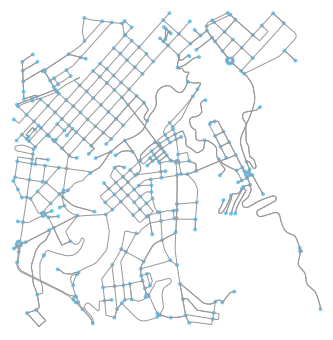

(<Figure size 542.061x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x188a6aec898>)

In [7]:
place = "panaca"
point = [38.69792, -0.47376]#[50.777236, 6.082777]
G=ox.graph_from_point(point, distance=1000,network_type='drive')
ox.plot_graph(G)

## Selecting n sites where n = 150

In [8]:
# list_cities_qry
list_cities_qry = list_vals[:150] 
print('Number or sites: ',len(list_cities_qry))
# print( list_cities_qry)
print('Number or cities:',len(set([l[0] for l in list_cities_qry])))
# list_cities_qry

Number or sites:  150
Number or cities: 26


In [9]:
## Preparing a dictionary of all sites for graph creation
count=0
dict_cities_qry = {}

for l in list_cities_qry:
    if l[1]+ ', '+l[0] not in dict_cities_qry:
        dict_cities_qry[count] = l
        count+=1
    else:
        print('ERR')
# print(len(dict_cities_qry))
dict_cities_qry

{0: ["'s-Hertogenbosch", "Saint John's Cathedral", 51.68808, 5.30814],
 1: ["'s-Hertogenbosch", 'The Moriaan', 51.68967, 5.30261],
 2: ["'s-Hertogenbosch", 'Town Hall', 51.68846, 5.30315],
 3: ["'s-Hertogenbosch", 'The North Brabant Museum', 51.68658, 5.30469],
 4: ["'s-Hertogenbosch", "City Museum 's-Hertogenbosch", 51.68575, 5.30419],
 5: ["'s-Hertogenbosch", 'Jhyeronimus Bosch Art Center', 51.68807, 5.31215],
 6: ["'s-Hertogenbosch", 'Citadel', 51.69511, 5.30335],
 7: ["'s-Hertogenbosch", 'Kruithuis', 51.69357, 5.30497],
 8: ['Aachen', 'Aachen Cathedral', 50.77475, 6.083922],
 9: ['Aachen', 'Cathedral Treasury', 50.775048, 6.08282],
 10: ['Aachen', 'Rathaus', 50.776025, 6.08389],
 11: ['Aachen',
  'Ludwig Forum für Internationale Kunst',
  50.781113,
  6.1017220000000005],
 12: ['Aachen', 'International Newspaper Museum', 50.777236, 6.082777],
 13: ['Aachen', 'Elisa Fountain', 50.774054, 6.086951],
 14: ['Aachen', 'Couven-Museum', 50.775698999999996, 6.084821],
 15: ['Aachen', 'Belv

## Construct a complete node weighted, edge weighted graph

In [10]:
G = nx.Graph()
for k,l in dict_cities_qry.items():
    G.add_node(k,lat=l[2],lon=l[3],data=l[1] + ', '+l[0])

node_list = list(G)

chance = 0.2
temp_list = []
for k,l in tqdm(dict_cities_qry.items()):
    city = k
    rand = random()
    for k2,l2 in dict_cities_qry.items():
        city2 = k2
        
        if [city,city2] not in temp_list and [city2,city] not in temp_list and city2 != city:
#             print(city,city2,count)
            dist_temp = calc_dist(l[2],l[3],l2[2],l2[3])
            G.add_edge(city,city2, dist=dist_temp)
            temp_list.append([city,city2])
        

# G.edges(data=True)

100%|████████████████████████████████████████| 150/150 [00:12<00:00, 11.62it/s]


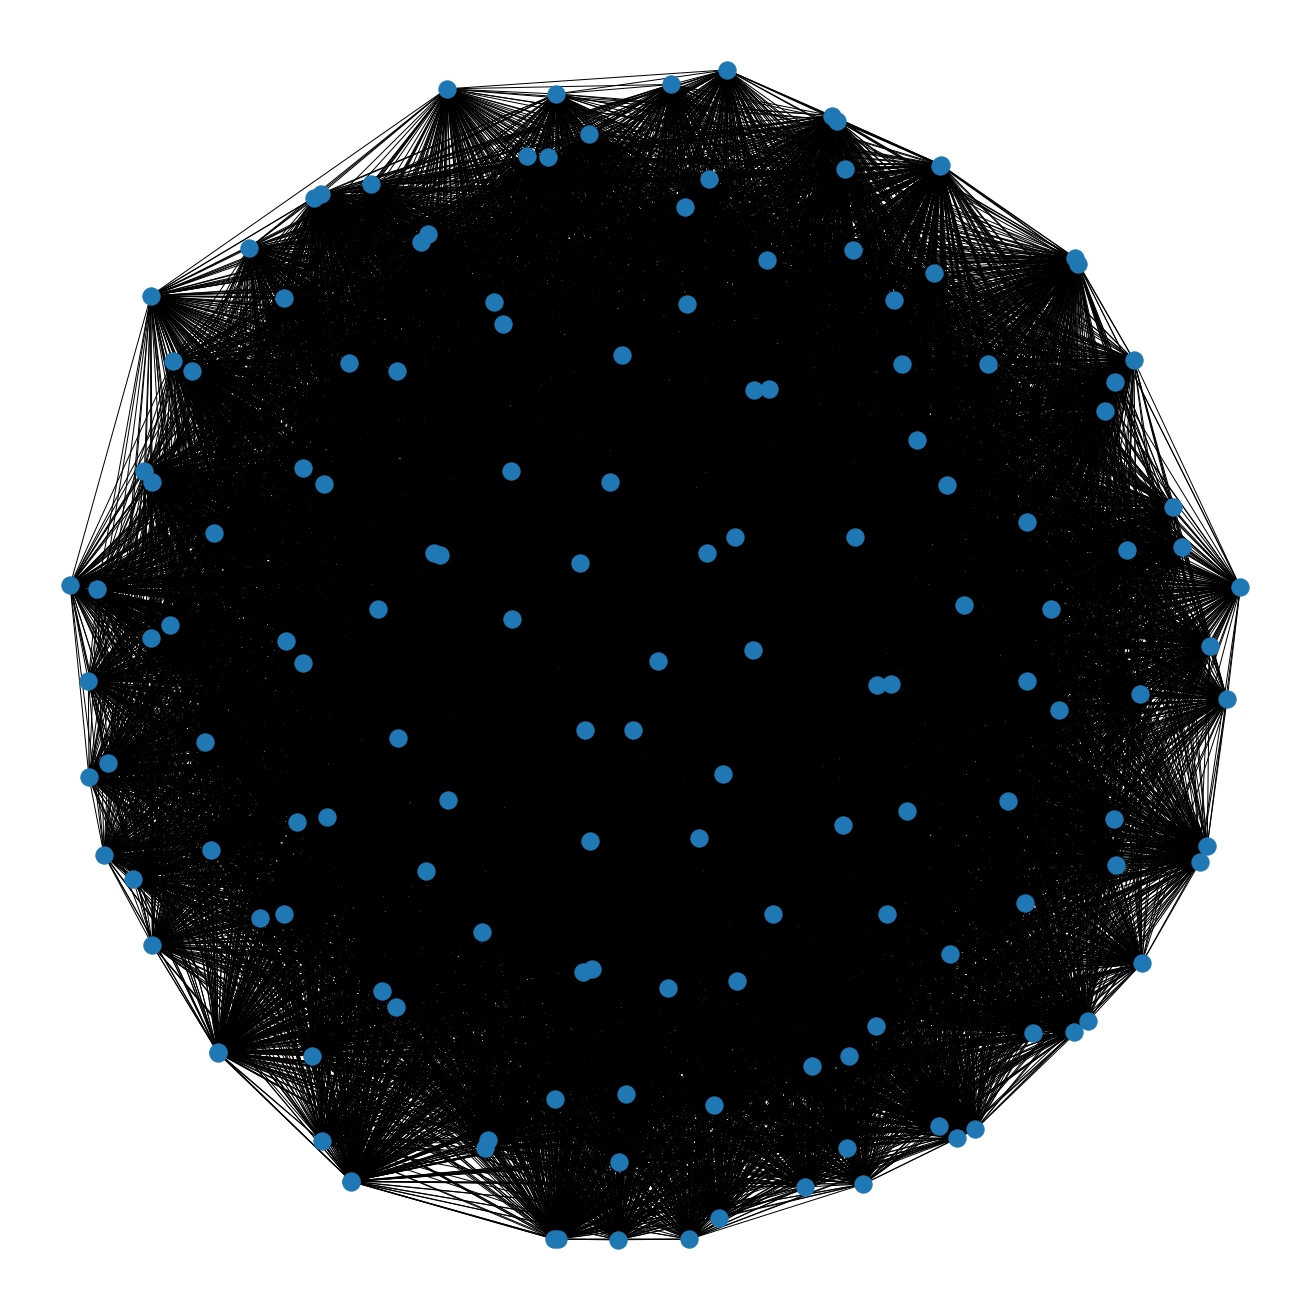

In [30]:
plt.figure(figsize=(18,18))
nx.draw(G,pos=nx.spring_layout(G), fontsize=1)
plt.savefig(figure_path + 'large_graph.png', type='png')

In [12]:
print('#nodes',len(G.nodes()))
print('#edges',len(G.edges))

#nodes 150
#edges 11175


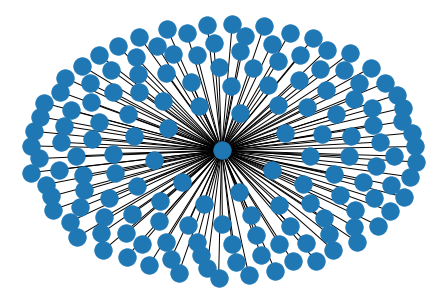

In [13]:
## Test to check if A* search is possible (answer:no, because of the star shape of the graph)
T = nx.minimum_spanning_tree(G,weight='weight')
nx.draw(T,pos=nx.spring_layout(T), fontsize=1)

## Genetic Algorithm Implementation

In [14]:
import random as rand

def fitness(route):
    sum_dist = 0.0
    for n in range(len(route[:-1])):
        sum_dist+=G.get_edge_data(route[n],route[n+1])['dist']
    sum_dist += G.get_edge_data(route[-1],route[0])['dist']
    return sum_dist

def random_route(nodes):
    return rand.sample(nodes, len(nodes))

def random_population(nodes,num_pop):
    return [random_route(nodes) for _ in range(num_pop)]

#rank pool of population in minimum fitness score order
def rank_pop(pop):
    fit = [fitness(i) for i in pop]
    return sorted(zip(fit,pop))

#Rectify duplicated nodes with unvisited nodes
def remove_duplicates(nodes, child):
    remaining_values = list(set(nodes) - set(child))
    if len(remaining_values) ==0:
        return child
    
    else:
        ## get duplicate value indices
        dict1 = defaultdict(list)
        for i,item in enumerate(child):
            dict1[item].append(i)
        dict1 = {k:v for k,v in dict1.items() if len(v)>1}
    #     print(dict1)

        for k, v in dict1.items():
            for i in v[1:]:
                child[i] = remaining_values.pop(0)

    #     print(len(set(child)))

        return child

def random_choice(list_of_parents):
    return rand.sample(list_of_parents,2)

def crossover(pop1,pop2):
    
    ##point crossover and point mutation implemented
    cross_point = int(rand.random()*len(node_list))
    
    parent1_start = pop1[:cross_point]
    parent1_end = pop1[cross_point:]
    parent2_start = pop2[:cross_point]
    parent2_end = pop2[cross_point:]
    
    assert len(parent1_start) == len(parent2_start)
    assert len(parent1_end) == len(parent2_end)

    temp1 = []
    for i in range(len(parent2_end)):
        if parent2_end[i] not in parent1_start and parent2_end[i] not in temp1:
            temp1.append(parent2_end[i])
        else:
            temp1.append(parent1_end[i])
    
#     print('parent1_start',len(parent1_start))
#     print('parent1_end',len(parent1_end))
#     print('temp1', len(temp1))

    
    
    temp2 = []
    for i in range(len(parent1_end)):
        if parent1_end[i] not in parent2_start and parent1_end[i] not in temp2:
            temp2.append(parent1_end[i])
        else:
            temp2.append(parent2_end[i])
            
#     print('parent2_start',len(parent2_start))
#     print('parent2_end',len(parent2_end))
#     print('temp2', len(temp2))
    
    child1 = remove_duplicates(node_list,parent1_start + temp1)
    child2 = remove_duplicates(node_list,parent2_start + temp2)
    

#     print(len(child1),'\n',len(child2))
#     print(child1,'\n',child2)

    assert len(child1)== len(set(child1))
    assert len(child2)== len(set(child2))
    
    return (child1,child2)

def mutate(pop):
    #point mutation
    randpoint1 = int(rand.random()*len(pop))
    randpoint2 = int(rand.random()*len(pop))

    while randpoint1 == randpoint2:
        randpoint1 = int(rand.random()*len(pop))
        randpoint2 = int(rand.random()*len(pop))
    
    temp = pop[randpoint1] 
    pop[randpoint1] = pop[randpoint2]
    pop[randpoint2] = temp
    
#     print (pop[randpoint1])
    return pop

#     assert len(child1) == len(set(child1))
#     assert len(child2) == len(set(child2))


## GA Functions Test

In [15]:
route = random_route(node_list)
print('route',len(route))
pop = random_population(node_list,4)
for p in pop:
    print('pop',len(p))
print('nodelist',len(node_list))

# fit = [fitness(i) for i in pop]
# print(fit)
# rpop = rank_pop(pop)
# print(rpop)
m = mutate(node_list)
print('mutated',len(m))
cx = crossover(node_list,random_route(node_list))
print('\n')
print(cx)


route 150
pop 150
pop 150
pop 150
pop 150
nodelist 150
mutated 150


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 104, 64, 79, 86, 136, 68, 69, 70, 81, 133, 73, 124, 75, 118, 77, 123, 116, 71, 93, 82, 83, 127, 105, 132, 87, 88, 95, 90, 91, 120, 141, 94, 144, 98, 97, 92, 84, 100, 125, 126, 103, 107, 128, 106, 113, 121, 137, 122, 111, 112, 85, 142, 115, 139, 108, 101, 119, 134, 72, 117, 102, 99, 78, 80, 67, 146, 63, 130, 131, 109, 129, 66, 135, 96, 147, 138, 89, 140, 74, 65, 143, 76, 110, 145, 114, 148, 149], [69, 111, 75, 20, 100, 119, 25, 82, 97, 135, 33, 59, 14, 41, 106, 130, 113, 149, 60, 74, 44, 131, 140, 103, 94, 10, 134, 49, 70, 8, 47, 138, 88, 80, 17, 21, 129, 89, 147, 16, 115, 102, 38, 53, 19, 146, 58, 34, 78, 29, 101, 143, 37, 24, 148, 76, 6, 39, 96, 99, 57, 61, 62, 63, 64, 65, 66, 

## GA main function

In [16]:
def GA(population_size=128, max_generations=2000, mutation_probability=0.40, countmax=10):
    
    time_list = [0]
    start_time = time.time()
    ## Get initial population and sort based on fitness
    pop = random_population(node_list,population_size)
    
    sorted_fitness = rank_pop(pop)
    
    ## Find best fitness
    best_fitness, best_path = sorted_fitness[0]
    parent_list_fitness = [i[0] for i in sorted_fitness]
    parent_list_path = [i[1] for i in sorted_fitness]
    
    list_best_scores = [best_fitness]

    print(parent_list_fitness)#, parent_list_path)
    
    print ('best fitness',best_fitness, best_path)
    
    count = 0
    temp_best_fitness = 0
    for g in range(max_generations):
        time_list.append(time.time()-start_time)
        large_array_of_paths = []
        for i in range(int(population_size/2)):
            
            parent1,parent2 = random_choice(parent_list_path)
#             print('parent len', len(parent1), len(parent2))
            child1,child2 = crossover(parent1, parent2)
            
            if rand.random()<mutation_probability:
                child1 = mutate(child1)
#                 print('mutated\n\n\n')
                
            if rand.random()<mutation_probability:
                child2 = mutate(child2)
#                 print('mutated\n\n\n')
            
            
            large_array_of_paths.extend([temp_pop for temp_pop in [parent1,parent2,child1,child2]])        
        
        temp_rank = rank_pop(large_array_of_paths+parent_list_path)
        
        if temp_rank[0][0]<best_fitness:
            best_fitness, best_path = temp_rank[0][0], temp_rank[0][1]
        list_best_scores.append(best_fitness)
        
        if best_fitness == temp_best_fitness:
            count+=1
            
        parent_list_fitness = [i[0] for i in temp_rank[:population_size]]
        parent_list_path = [i[1] for i in temp_rank[:population_size]]
        
        if count >= countmax:
            break
            
    temp_best_fitness = best_fitness
    time_list.append(time.time()-start_time)
    return best_fitness,best_path, time_list, list_best_scores

In [17]:
GA_fitness, GA_path, time_list,list_best_scores = GA()
GA_fitness,GA_path,time_list


[426160.9500402013, 427967.56416262855, 429086.0756642249, 429735.6002952967, 432306.71355502086, 432703.5418532191, 432841.7243592343, 433405.55543884955, 434320.9334644331, 435154.0434113435, 435436.9672401941, 437924.9975970883, 438080.4897944575, 438345.0269259666, 438875.0740977995, 440636.4666605966, 441165.63914228545, 441199.4896169786, 441314.83562819567, 441339.6416598243, 441571.5384183419, 441789.78658640163, 442041.45909426815, 443071.3124573716, 443206.44879024115, 443398.7044416161, 443779.9929316231, 444780.4036619843, 445047.25770068495, 445870.9794683413, 445904.75693530426, 446808.3358829553, 446979.82393294555, 447455.1957967635, 447871.19862553413, 447939.31742258376, 447973.6323178942, 448446.6216655349, 448648.3328642297, 449205.4949387343, 449239.149542993, 449774.4849483116, 449978.3795448592, 450136.4049428029, 450306.70597153227, 450428.4917604864, 450734.05882412056, 451252.30043961253, 451405.88577472384, 451480.7622469626, 451958.6292609713, 452373.6134892

(124923.13086886733,
 [2,
  4,
  141,
  139,
  148,
  125,
  137,
  138,
  140,
  136,
  102,
  101,
  106,
  120,
  44,
  45,
  47,
  41,
  78,
  77,
  76,
  149,
  147,
  146,
  3,
  0,
  5,
  57,
  68,
  70,
  63,
  72,
  74,
  50,
  55,
  53,
  61,
  75,
  69,
  66,
  89,
  90,
  85,
  81,
  35,
  24,
  37,
  33,
  26,
  21,
  19,
  17,
  10,
  8,
  20,
  48,
  49,
  115,
  114,
  116,
  117,
  22,
  16,
  12,
  15,
  71,
  73,
  40,
  28,
  30,
  38,
  25,
  36,
  27,
  29,
  31,
  39,
  32,
  123,
  121,
  122,
  145,
  96,
  95,
  109,
  110,
  124,
  143,
  144,
  142,
  79,
  13,
  18,
  134,
  135,
  128,
  131,
  126,
  129,
  51,
  52,
  54,
  60,
  59,
  65,
  62,
  64,
  104,
  105,
  42,
  34,
  23,
  67,
  58,
  56,
  132,
  127,
  133,
  130,
  82,
  84,
  88,
  87,
  80,
  86,
  83,
  92,
  91,
  94,
  93,
  99,
  97,
  100,
  98,
  112,
  113,
  11,
  14,
  9,
  43,
  46,
  119,
  118,
  103,
  108,
  111,
  107,
  6,
  7,
  1],
 [0,
  0.04097723960876465,
  0.145917

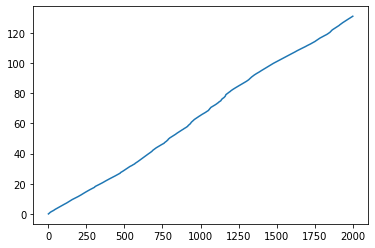

In [33]:
plt.plot(time_list)

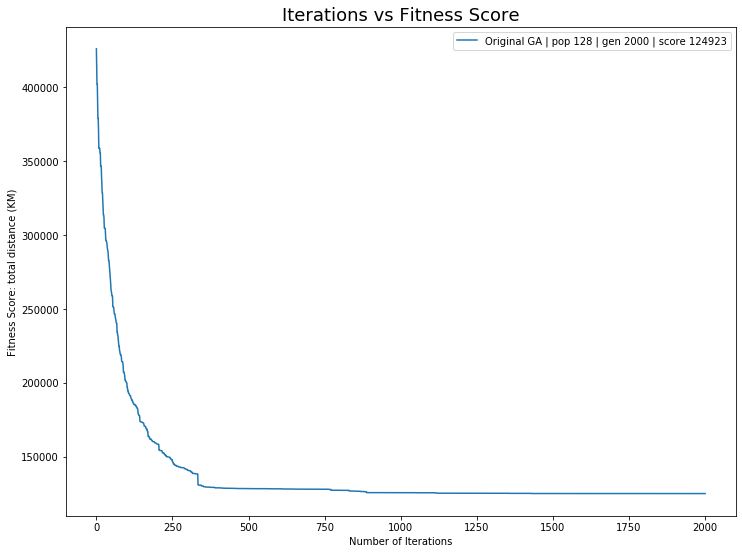

In [34]:
plt.figure(figsize=(12,9))
plt.plot(range(len(list_best_scores)), list_best_scores, label='Original GA | pop 128 | gen 2000 | score {}'.format(int(GA_fitness)))
plt.title('Iterations vs Fitness Score', fontsize=18)
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness Score: total distance (KM)')
plt.legend()
plt.savefig(figure_path + 'iterations_vs_fitness_GA_orig.png', type='png')

## Implementation of greedy best first Search Algorithm

In [19]:
### Functions

def get_best_node(start_node,goal_node,path):
    d = G[start_node]
    bestk = 0
    bestdist = 1000000

    dict_scores = {}

    for k,v in d.items():
        if k != goal_node and k not in path:
            dict_scores[k] = v['dist'] + G.get_edge_data(k,goal_node)['dist']
#     print(dict_scores)
    return min(dict_scores,key=dict_scores.get)

def best_first_heuristic(nodes, Graph=G):
    
    start_node = nodes[0]
    goal_node = nodes[-1]
    best_node = start_node
    path = [start_node]
#     print(path)
    while len(path)<len(nodes)-1:
        best_node = get_best_node(best_node,goal_node,path)
        path.append(best_node)  
    final_path = path + [goal_node]
#     print(final_path)
    assert len(final_path) == len(set(final_path))
    return final_path
    
    
    

In [36]:
bfh_path = best_first_heuristic(GA_path)
print("Original GA: ",fitness(GA_path))
print("BFH after GA: ",fitness(bfh_path))

Original GA:  124923.13086886733
BFH after GA:  48918.372979080814


## GA with two step BFH pooling

In [21]:
def GA_with_bfs_pooling(population_size=128, max_generations=5, mutation_probability=0.40,countmax= 10):
    

    start_time = time.time()
    time_list = [0]
    ## Get initial population and sort based on fitness
    pop = random_population(node_list,population_size)
    
    sorted_fitness = rank_pop(pop)
    
    ## Find best fitness
    best_fitness, best_path = sorted_fitness[0]
    parent_list_fitness = [i[0] for i in sorted_fitness]
    parent_list_path = [i[1] for i in sorted_fitness]
    
    list_best_scores = [best_fitness]

    print(parent_list_fitness)#, parent_list_path)
    
    print ('best fitness',best_fitness, best_path)
    
    count=0
    temp_best_fitness = best_fitness
    for g in trange(max_generations):
        time_list.append(time.time()-start_time)
        large_array_of_paths = []
        for i in range(int(population_size/2)):
            
            parent1,parent2 = random_choice(parent_list_path)
#             print('parent len', len(parent1), len(parent2))
            child1,child2 = crossover(parent1, parent2)
            
            if rand.random()<mutation_probability:
                child1 = mutate(child1)
#                 print('mutated\n\n\n')
                
            if rand.random()<mutation_probability:
                child2 = mutate(child2)
#                 print('mutated\n\n\n')
            
            
            large_array_of_paths.extend([temp_pop for temp_pop in [parent1,parent2,child1,child2]])
        
#         temp_rank = rank_pop(large_array_of_paths)
        
#         if temp_rank[0][0]<best_fitness:
#             best_fitness, best_path = temp_rank[0][0], temp_rank[0][1]
        
        
        temp_rank = rank_pop(large_array_of_paths+parent_list_path)
        
#         parent_list_fitness = [i[0] for i in temp_rank2[:population_size]]

        temp_list_path = [i[1] for i in temp_rank[:population_size]]
    
        bfh_on_temp_list_path = [best_first_heuristic(p) for p in temp_list_path]
        
        temp_rank2 = rank_pop(bfh_on_temp_list_path + temp_list_path)
        
        if temp_rank2[0][0]<best_fitness:
            best_fitness, best_path = temp_rank[0][0], temp_rank[0][1]
        list_best_scores.append(best_fitness)
        
        if best_fitness == temp_best_fitness:
            count+=1
        
        parent_list_fitness = [i[0] for i in temp_rank2[:population_size]]
        parent_list_path = [i[1] for i in temp_rank2[:population_size]]
        
        if count >= countmax:
            break
    temp_best_fitness = best_fitness
    time_list.append(time.time()-start_time)
    return best_fitness,best_path, time_list,list_best_scores

In [22]:
GA_bfh_fitness, GA_bfh_path, bfh_time_list,list_best_scores_bfh = GA_with_bfs_pooling()
GA_bfh_fitness,GA_bfh_path,bfh_time_list

  0%|                                                    | 0/5 [00:00<?, ?it/s]

[418509.05393907375, 420239.3935687661, 421635.73811787093, 424573.12060890417, 424583.03877773095, 425346.5232259085, 425779.46024769725, 428659.2964770849, 429028.6333871622, 430195.83533879777, 430256.74944931053, 430316.0006988375, 431396.89060010866, 431513.5217941514, 434378.83436830447, 435619.03202343517, 435714.0027580316, 436019.39896269277, 436696.0761271427, 437142.5095434105, 437890.13866306754, 438505.65703203366, 438524.66057770234, 438733.16607596725, 439158.6955827576, 439902.26220439887, 440129.95003949205, 440204.5582424826, 440454.13067791023, 441164.15327139373, 441869.54013764806, 443503.051202155, 444165.3802564517, 444434.2172001761, 444600.7284446496, 444755.578601296, 445478.44109351916, 445528.4833568455, 446793.9001347237, 447102.6878211328, 447551.4112784393, 447568.8654269021, 447949.24173890846, 448180.01654266036, 449280.2780937181, 449704.47809564526, 450597.69727841066, 452447.83884098125, 452803.5836218083, 452857.4882668809, 452954.74844079436, 45362

100%|████████████████████████████████████████████| 5/5 [00:35<00:00,  7.01s/it]


(47773.451400417995,
 [112,
  113,
  129,
  133,
  127,
  132,
  128,
  131,
  126,
  135,
  134,
  49,
  48,
  18,
  11,
  13,
  14,
  10,
  17,
  8,
  22,
  16,
  9,
  20,
  12,
  19,
  15,
  21,
  5,
  0,
  3,
  4,
  2,
  1,
  7,
  6,
  43,
  47,
  45,
  44,
  46,
  71,
  57,
  68,
  70,
  63,
  72,
  75,
  69,
  74,
  56,
  51,
  50,
  52,
  55,
  61,
  53,
  54,
  64,
  60,
  59,
  65,
  62,
  58,
  73,
  66,
  67,
  41,
  38,
  25,
  30,
  31,
  29,
  27,
  36,
  28,
  37,
  39,
  40,
  33,
  26,
  23,
  24,
  35,
  34,
  32,
  42,
  81,
  88,
  84,
  87,
  85,
  80,
  82,
  89,
  90,
  86,
  83,
  92,
  91,
  94,
  93,
  95,
  96,
  98,
  100,
  97,
  99,
  119,
  118,
  120,
  104,
  106,
  102,
  101,
  103,
  105,
  107,
  110,
  111,
  108,
  109,
  79,
  136,
  140,
  141,
  137,
  138,
  139,
  125,
  148,
  149,
  147,
  146,
  115,
  114,
  116,
  117,
  145,
  124,
  143,
  144,
  142,
  122,
  121,
  123,
  78,
  77,
  76,
  130],
 [0,
  0.06696343421936035,
  7.362858

In [23]:
GA_bfh_fitness_p8, GA_bfh_path_p8, bfh_time_list_p8,list_best_scores_bfh_p8 = GA_with_bfs_pooling(population_size=8)
GA_bfh_fitness_p8,GA_bfh_path_p8,bfh_time_list_p8

  0%|                                                    | 0/5 [00:00<?, ?it/s]

[430759.46284130856, 432765.9055783516, 446788.0928708123, 447931.3206036487, 466769.2481933403, 468776.2372582594, 469866.88934070134, 481601.79856504453]
best fitness 430759.46284130856 [117, 60, 51, 76, 125, 42, 102, 65, 123, 121, 142, 44, 138, 115, 82, 10, 7, 18, 54, 112, 14, 73, 147, 143, 72, 25, 63, 79, 74, 109, 81, 144, 31, 66, 70, 128, 148, 17, 118, 4, 89, 2, 91, 1, 83, 129, 71, 29, 101, 38, 108, 69, 26, 46, 9, 50, 119, 93, 87, 8, 35, 131, 59, 90, 122, 16, 64, 34, 104, 86, 130, 95, 67, 139, 124, 39, 40, 106, 98, 62, 94, 23, 32, 22, 134, 13, 61, 120, 105, 11, 48, 30, 45, 97, 36, 47, 114, 0, 58, 132, 146, 133, 41, 5, 49, 77, 80, 111, 103, 88, 110, 27, 127, 15, 99, 100, 33, 6, 53, 20, 107, 19, 116, 137, 55, 135, 12, 85, 3, 84, 28, 92, 136, 96, 149, 145, 43, 21, 56, 126, 37, 141, 78, 57, 140, 24, 52, 68, 75, 113]


100%|████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


(48423.72786270473,
 [81,
  88,
  87,
  85,
  90,
  80,
  84,
  82,
  86,
  83,
  92,
  91,
  98,
  100,
  97,
  99,
  93,
  95,
  96,
  94,
  109,
  111,
  108,
  110,
  107,
  79,
  105,
  104,
  106,
  103,
  101,
  102,
  118,
  119,
  120,
  46,
  44,
  45,
  47,
  43,
  6,
  7,
  1,
  2,
  3,
  4,
  0,
  5,
  21,
  15,
  19,
  12,
  17,
  10,
  14,
  9,
  16,
  8,
  22,
  13,
  18,
  11,
  20,
  66,
  64,
  54,
  53,
  55,
  61,
  52,
  60,
  59,
  65,
  58,
  62,
  50,
  51,
  56,
  74,
  73,
  67,
  75,
  69,
  72,
  63,
  70,
  68,
  57,
  71,
  42,
  34,
  35,
  24,
  33,
  26,
  23,
  40,
  37,
  28,
  27,
  29,
  36,
  30,
  31,
  39,
  25,
  38,
  32,
  41,
  48,
  49,
  134,
  135,
  132,
  127,
  128,
  130,
  133,
  131,
  126,
  129,
  113,
  112,
  136,
  140,
  141,
  137,
  138,
  139,
  125,
  148,
  149,
  146,
  147,
  117,
  116,
  114,
  115,
  145,
  124,
  143,
  144,
  142,
  122,
  121,
  123,
  78,
  77,
  76,
  89],
 [0,
  0.014991283416748047,
  0.601659

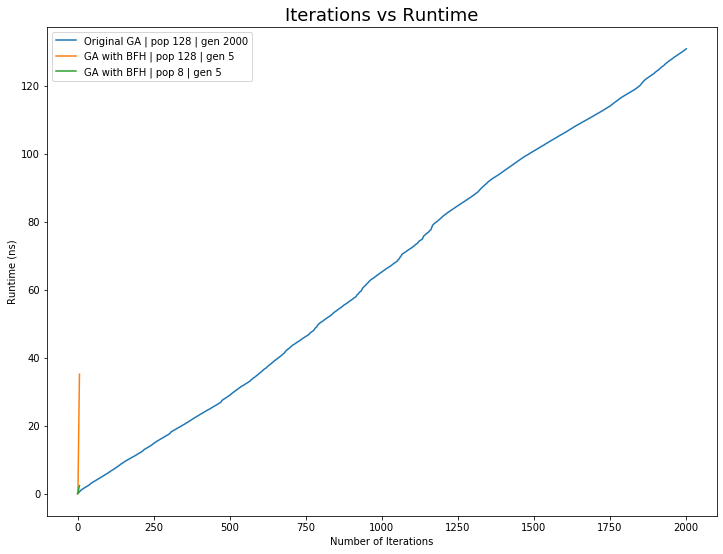

In [31]:
plt.figure(figsize=(12,9))
plt.plot(time_list,label='Original GA | pop 128 | gen 2000')
plt.plot(bfh_time_list, label='GA with BFH | pop 128 | gen 5')
plt.plot(bfh_time_list_p8, label='GA with BFH | pop 8 | gen 5')
plt.title('Iterations vs Runtime', fontsize=18)
plt.xlabel('Number of Iterations')
plt.ylabel('Runtime (ns)')
plt.legend()
plt.savefig(figure_path + 'iterations_vs_runtime.png', type='png')

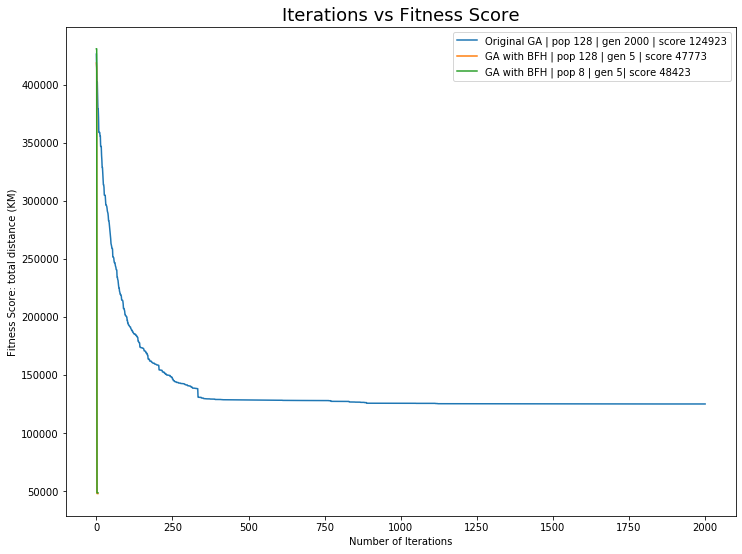

In [32]:
plt.figure(figsize=(12,9))
plt.plot(range(len(list_best_scores)), list_best_scores, label='Original GA | pop 128 | gen 2000 | score {}'.format(int(GA_fitness)))
plt.plot(range(len(list_best_scores_bfh)), list_best_scores_bfh, label='GA with BFH | pop 128 | gen 5 | score {}'.format(int(GA_bfh_fitness)))
plt.plot(range(len(list_best_scores_bfh_p8)), list_best_scores_bfh_p8, label='GA with BFH | pop 8 | gen 5| score {}'.format(int(GA_bfh_fitness_p8)))
plt.title('Iterations vs Fitness Score', fontsize=18)
plt.xlabel('Number of Iterations')
plt.ylabel('Fitness Score: total distance (KM)')
plt.legend()
plt.savefig(figure_path + 'iterations_vs_fitness.png', type='png')

In [26]:
bfh_time_list

[0,
 0.06696343421936035,
 7.362858533859253,
 14.03212285041809,
 21.530883312225342,
 28.381026029586792,
 35.11523509025574]

In [27]:
list_best_scores, list_best_scores_bfh

([426160.9500402013,
  411676.2861894997,
  402093.30382356554,
  402093.30382356554,
  389868.6199739678,
  379114.2248036291,
  379114.2248036291,
  371695.7681019483,
  358739.5477368585,
  358739.5477368585,
  358739.5477368585,
  358739.5477368585,
  355622.4251245085,
  355622.4251245085,
  346687.60486369336,
  346687.60486369336,
  346687.60486369336,
  339092.38461290044,
  334948.67203879694,
  328535.8162188729,
  328535.8162188729,
  323427.5506953887,
  316485.15725132206,
  313625.8202431191,
  313625.8202431191,
  311441.3377419424,
  304745.10429903865,
  304745.10429903865,
  304745.10429903865,
  304664.4650425107,
  300214.06070328876,
  296297.2935760913,
  296297.2935760913,
  295629.5274084805,
  295151.92705661635,
  293431.4603720089,
  291056.2199115494,
  290133.58364310244,
  289071.0467858464,
  286633.2704793341,
  282811.2427630298,
  282811.2427630298,
  280933.89361869363,
  278231.43907021935,
  275807.0566914696,
  272888.5024860059,
  269780.633287781